# Wykorzystanie indeksu wegetacji NDVI do klasyfikacji gatunków drzew
# Rafał Borkowski


# Pochodzenie danych

# Spis treści:
1. Pochodzenie źródła danych
2. Etap 0 - preprocesing i przygotowanie
3. Obliczanie indeksu NDVI
4. Przetwarzanie próbek na dane
5. Przykładowe dane
6. Import bibliotek i funkcji
7. Wartości histogramu

# Pochodzenie źródła danych

**Źródłem danych** są lotnicze zdjęcia spektralne wykonane w barwach widzialnych (RGB) oraz bliskiej podczerwieni (NIR) dostępne na [Geoportalu krajowym](https://mapy.geoportal.gov.pl/imap/Imgp_2.html?gpmap=gp0).

**Obszarem zainteresowań** objęty jest zwarty obszar leśny Nadleśnictwa Doświadczalnego Zielonka [52º31' N, 17º4' E]( https://www.wspolrzedne.pl/?szer=52.531663485504446&dlug=17.076341745854453&zoom=12). 

# Etap 0 - preprocesing i przygotowanie


Po pobraniu zdjęcia lotnicze w formacie .tif zostały wczytane do programu [QGIS](https://qgis.org/en/site/) będącym otwartym oprogramowaniem geoinformacyjnym.
Korzystając z danych dotyczących drzewostanów, dostępnych na stronie [Banku Danych o Lasach](https://www.bdl.lasy.gov.pl/portal/) wytypowano zwarte, jednogatunkowe drzewostany sosny zwyczajnej (*Pinus sylvestris*) oraz dębu (*Quercus spp*). Wybrano drzewostany, których wiek jest zbliżony do średniego wieku dla danego gatunku wewnątrz kompleksu leśnego. 

**Dla dębu**:
- 153 lata,
- 158 lat,
- 159 lat.

**Dla sosny**:
- 54 lata,
- 55 lat,
- 58 lat.

Kolejnym krokiem było wykorzystanie wtyczki [QRectangleCreator](https://plugins.qgis.org/plugins/QRectangleCreator/) do generowania próbek drzew. Wtyczka ta umożliwia definiowanie predefiniowanych kształtów poligonów, w naszym przypadku kwadratów o wymiarach 2x2 metrów. Na podstawie oceny wizualnej, wyznaczono lokalizacje tych poligonów, które odpowiadały **koronom drzew** na zdjęciach spektralnych. Ze względu na rozmiar korony w przypadku dębu możliwe było wyznaczenie więcej, niż jednego poligonu z jednej korony drzewa. Ważne było pozyskanie próbki indeksu wegetacji NDVI.

**Rycina 1** prezentuje koncept pozyskiwania danych.

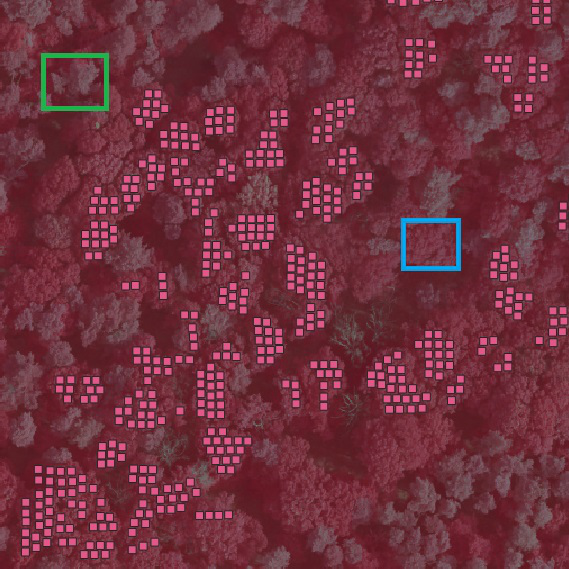

In [7]:
from IPython.display import display
from PIL import Image

def show_image(image_path):
    image = Image.open(image_path)
    display(image)

image_path = "C:/python_zaliczenie/jpg/fig1.jpg"
show_image(image_path)


Na powyższej ilustracji widzimy fragment zdjęcia spektralnego w kompozycji barw umownych (**CIR**). Często wykorzystywaną techniką jest CIR (*Color Infrared*), gdzie roślinność przedstawiona jest w czerwieni. Dzięki zastosowaniu podczerwieni widoczne jest **zróżnicowanie gatunkowe**. Niebieskim prostokątem oznaczona została przykładowa korona dębu, zielonym prostokątem przykładowe korona sosny. Różowe prostokąty to poligony próbkujące, w tym przypadku fragmenty koron dębów. 

## Obliczanie indeksu NDVI

Założeniem projektu była hipoteza twierdząca, że na podstawie indeksu wegetacji **NDVI** możliwe jest rozróznienie gatunków drzew. NDVI (*Normalized Difference Vegetation Index*), czyli znormalizowany indeks wegetacji to wskaźnik stosowany do oceny aktywności wegetacyjnej roślin na podstawie różnicy wchłaniania światła w obszarach podczerwieni i bliskiej podczerwieni. Jego wartości skorelowane są z zawartością chlorofilu. 

NDVI przyjmuje postać:

NDVI = (NIR - RED) / (NIR + RED), gdzie

NIR to wartość odbicia promieniowania w bliskiej podczerieni,
RED to wartość odbicia promieniowania w zakrsie czerwonym światła widzialnego.

Wskaźnik NDVI przyjmuje wartości z zakresu -1 do 1.

# Przetwarzanie próbek na dane

Przykład kodu, do pozyskiwania statystyk z przygotowanych próbek. Podajemy folder z próbkami poligonów NDVI oraz folder wynikowoy dla pliku CSV. 

Przeliczane są następujące wartości:
- liczba pixeli w poligonie,
- wartość minimalna,
- wartość maksymalna,
- wartość średnia,
- odchylenie standardowe.



In [ ]:
"""
import rasterio
import pandas as pd
import glob
import numpy as np
import os
import time  # Dodaj ten import!

import tkinter as tk
from tkinter import filedialog

def calculate_raster_statistics(input_folder, output_csv):
    # Lista rastrów do przetworzenia
    raster_list = glob.glob(os.path.join(input_folder, '*.tif'))

    # Tworzenie pustego dataframe'u do przechowywania wyników
    results_df = pd.DataFrame()

    # Pętla przez rastry
    start_time = time.time()  # Początkowy czas
    for raster_path in raster_list:
        with rasterio.open(raster_path) as src:
            raster = src.read(1)

            # Obliczanie statystyk
            min_val = np.min(raster)
            max_val = np.max(raster)
            mean_val = np.mean(raster)
            std_val = np.std(raster)
            count_val = np.count_nonzero(~np.isnan(raster))

            # Tworzenie dataframe'u ze statystykami
            df = pd.DataFrame({
                'Raster': [raster_path],
                'Count': [count_val],
                'Min': [min_val],
                'Max': [max_val],
                'Mean': [mean_val],
                'Std': [std_val]

            })

            # Łączenie wyniku z dataframe'em wyników
            results_df = pd.concat([results_df, df])

    # Zapisanie wyników do pliku CSV
    results_df.to_csv(output_csv, index=False)
    elapsed_time = time.time() - start_time  # Czas trwania obliczeń
    print(f"Wyniki zostały zapisane do: {output_csv}")
    print(f"Czas trwania obliczeń: {elapsed_time:.2f} sekundy")

# Tworzymy GUI z pomocą tkinter
root = tk.Tk()
root.withdraw()  # Ukrywamy główne okno, ponieważ nie potrzebujemy pełnej aplikacji GUI

# Wybierz folder z rastrami
input_folder = filedialog.askdirectory(title="Wybierz folder z rastrami")

# Sprawdź, czy użytkownik wybrał folder
if not input_folder:
    print("Anulowano wybór folderu z rastrami.")
else:
    # Wybierz ścieżkę do zapisu pliku CSV
    output_csv = filedialog.asksaveasfilename(
        title="Wybierz miejsce zapisu pliku CSV",
        defaultextension=".csv",
        filetypes=[("CSV Files", "*.csv")]
    )

    # Sprawdź, czy użytkownik wybrał miejsce zapisu
    if not output_csv:
        print("Anulowano wybór miejsca zapisu pliku CSV.")
    else:
        # Wywołaj funkcję przetwarzania z wybranymi ścieżkami
        calculate_raster_statistics(input_folder, output_csv
"""

# Przykładowe dane

Wyjaśnienie danych:
- **id** - numer id każdej próbki
- **min** - minimalna wartość indeksu NDVI
- **max** - maksymalna wartość indeksu NDVI
- **mean** -  średnia wartość indeksu NDVI
- **std** -  odchylenie standardowe wartość indeksu NDVI
- **count** - liczba pixeli w poligonie
- **species** - gatunek drzewa
- **age** - wiek drzewostanu
- **tsl** - typ siedliskowy lasu; cecha lasu świadcząca o żyzności siedliska

In [3]:
import pandas as pd
df = pd.read_csv(r"C:\python_zaliczenie\CSV\trees.csv", delimiter=";")
print(df)

         id  tree_id       min       max      mean       std  count species  \
0      5640        0  0.238095  0.489933  0.352131  0.054493    156      DB   
1      5641        1  0.203791  0.537415  0.421799  0.072868    156      DB   
2      5642       10  0.210762  0.513889  0.427296  0.053479    144      DB   
3      5643      100  0.362162  0.609023  0.531492  0.045743    169      DB   
4      5644     1000  0.283019  0.570470  0.441266  0.069439    144      DB   
...     ...      ...       ...       ...       ...       ...    ...     ...   
5633  11273       95  0.300000  0.611940  0.460505  0.076445    156      DB   
5634  11274       96  0.227273  0.594595  0.432737  0.073367    156      DB   
5635  11275       97  0.252336  0.572414  0.436175  0.070488    144      DB   
5636  11276       98  0.227907  0.594406  0.407233  0.073816    156      DB   
5637  11277       99  0.285714  0.664122  0.482923  0.079463    156      DB   

      age  tsl  
0     153  LSW  
1     153  LSW  


# Główne statystyki zbioru

**Liczba obserwacji** = 5638
**Liczba kolumn** = 10

**Liczba obserwacji w podziale na gatunek i wiek**


| species | age | liczba obserwacji |
|---------|-----|-------------------|
| DB      | 153 | 1081              |
| DB      | 158 | 893               |
| DB      | 159 | 1026              |
| SO      | 54  | 333               |
| SO      | 55  | 1329              |
| SO      | 58  | 976               |
-------------------------------------

**Średnia wartość parametru NDVI dla zbioru** = **0.30291**

**Średnia wartość parametru NDVI w podziele na gatunki:**

**DB** = 0,424301
**SO** = 0,164860


0   976

## Średnia wartośćc parametru NDVI w podziale na gatunki i wiek

| species | age   | 54       | 55       | 58       | 153      | 158      | 159      |
|---------|-------|----------|----------|----------|----------|----------|----------|
| DB      |       | NaN      | NaN      | NaN      | 0.429681 | 0.416908 | 0.425066 |
| SO      |       | 0.164    | 0.149983 | 0.185314 | NaN      | NaN      | NaN      |


## Analiza danych
# Import bibliotek i funkcji


In [12]:
#import bibliotek

import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns


In [43]:
### import funkcji ###
# wczytywanie zboru danych do data frame'u
def read_csv_pandas(path_to_file):
    df = pd.read_csv(path_to_file,sep=';')
    return(df)

# Tworzenie histogramu danych
def plot_histogram_all(df, colors):
    grouped_df = df.groupby('species')

    for (species, group), color in zip(grouped_df, colors):
        plt.hist(group['mean'], label=species, alpha=0.5, color=color, edgecolor='black')
        mean_value = group['mean'].mean()
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean ({species}): {mean_value:.2f}')

    plt.title('Histogram wartości średnich według gatunku')
    plt.xlabel('Wartości średnie NDVI')
    plt.ylabel('Częstotliwość')
    plt.legend()

    plt.show()
    
# Histogram danych z podziałem na gatunek
def plot_histogram(df, species, color):
    df_species = df[df['species'] == species]

    # Tworzymy histogram z kolorem ramki wokół prostokątów
    plt.hist(df_species['mean'], bins=40, label=species, alpha=0.5, edgecolor='black', color=color)

    # Dodajemy linię reprezentującą średnią wartość
    mean_value = df_species['mean'].mean()
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

    # Ustawiamy etykiety osi
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')

    # Ustawiamy zakres osi x od minimum do maksimum danych
    plt.xlim(df_species['mean'].min(), df_species['mean'].max())

    # Dodajemy legendę
    plt.legend()

    # Dodajemy tytuł
    plt.title(f'Histogram dla species=\'{species}\'')

    # Wyświetlamy histogram
    plt.show()

# Statystyki opisowe
def descriptive_statistics(data, species):
    # Filtrujemy dane dla danego gatunku
    data_species = data[data['species'] == species]['mean']

    # Miary pozycyjne
    mean_value = data_species.mean()
    median_value = data_species.median()
    mode_value = data_species.mode().iloc[0]  # Mode może mieć więcej niż jedną wartość, dlatego wybieramy pierwszą

    # Miary przeciętne
    arithmetic_mean = data_species.mean()
    harmonic_mean = 1 / (1 / data_species).mean()
    geometric_mean = data_species.prod() ** (1 / len(data_species))

    # Miary zmienności klasyczne
    variance_value = data_species.var()
    std_deviation_value = data_species.std()

    # Miary pozycyjne dla zmiennych ilościowych
    q1 = data_species.quantile(0.25)
    q3 = data_species.quantile(0.75)
    interquartile_range = q3 - q1

    # Wyświetlanie wyników
    print(f"Statystyki opisowe dla gatunku '{species}':")
    print("\nMiary pozycyjne:")
    print(f"Średnia arytmetyczna: {mean_value}")
    print(f"Mediana: {median_value}")
    print(f"Moda: {mode_value}")

    print("\nMiary przeciętne:")
    print(f"Średnia arytmetyczna: {arithmetic_mean}")
    print(f"Średnia harmoniczna: {harmonic_mean}")
    print(f"Średnia geometryczna: {geometric_mean}")

    print("\nMiary zmienności klasyczne:")
    print(f"Wariancja: {variance_value}")
    print(f"Odchylenie standardowe: {std_deviation_value}")

    print("\nMiary pozycyjne dla zmiennych ilościowych:")
    print(f"Kwartyl 1 (Q1): {q1}")
    print(f"Kwartyl 3 (Q3): {q3}")
    print(f"Rozstęp międzykwartylowy: {interquartile_range}")

# Test normalności rozkładu
def assess_normality(data, species):
    # Filtrujemy dane dla danego gatunku
    data_species = data[data['species'] == species]['mean']

    # Wykres QQ
    qqplot(data_species, line='s')
    plt.title(f'Q-Q Plot dla gatunku {species}')
    plt.show()

    # Histogram
    plt.hist(data_species, bins=20, density=True, alpha=0.5, color='grey', edgecolor='black')
    plt.title(f'Histogram dla gatunku {species}')
    plt.xlabel('Wartości średnie')
    plt.ylabel('Częstotliwość')
    plt.show()

    # Test Shapiro-Wilka
    stat, p_value = shapiro(data_species)
    print(f'Test Shapiro-Wilka dla gatunku {species}:')
    print(f'Statystyka testowa: {stat}')
    print(f'Wartość p: {p_value}')
    if p_value > 0.05:
        print('Nie ma podstaw do odrzucenia hipotezy zerowej - dane mogą pochodzić z rozkładu normalnego.')
    else:
        print('Hipoteza zerowa (rozkład normalny) jest odrzucana.')

#
def compare_groups(data, group1_name, group2_name):
    # Wyodrębnienie grup
    group1 = data[data['species'] == group1_name]['mean']
    group2 = data[data['species'] == group2_name]['mean']

    # Przeprowadzenie testu U Manna-Whitneya
    u_stat, p_value = mannwhitneyu(group1, group2)
    print(f"Test U Manna-Whitneya: statystyka U = {u_stat}, p-wartość = {p_value}")

    # Wykres pudełkowy dla obu grup
    sns.boxplot(x='species', y='mean', data=data)
    plt.title(f'Porównanie grup {group1_name} i {group2_name}')
    plt.xlabel('Species')
    plt.ylabel('Mean Value')
    plt.show()


def compare_wilcoxon(data, group1_name, group2_name, alpha=0.05):
    # Wyodrębnienie grup
    group1 = data[data['species'] == group1_name]['mean']
    group2 = data[data['species'] == group2_name]['mean']

    # Test Wilcoxona dla dwóch grup
    stat, p_value = wilcoxon(group1, group2)

    # Sprawdzenie istotności statystycznej i wypisanie wyniku
    if p_value < alpha:
        print("Istnieją istotne różnice między grupami.")
    else:
        print("Brak istotnych różnic między grupami.")

    return stat, p_value


In [27]:

# podstawowe statystyki zbioru
df = read_csv_pandas(r'C:\python_zaliczenie\CSV\trees.csv')
print("Liczba obserwacji, liczba kolumn")
print(df.shape)
print("\n")

#Ilość obserwacji w przeiczeniu na gatuenk i wiek
counts = df.groupby(['species', 'age']).size()
print("Liczba obeserwacji: ")
print(counts)

Liczba obserwacji, liczba kolumn
(5638, 10)


Liczba obeserwacji: 
species  age
DB       153    1081
         158     893
         159    1026
SO       54      333
         55     1329
         58      976
dtype: int64


In [28]:
#Średnia wartość parametru NDVI
print(df['mean'].mean())



0.30290945529230223


In [29]:
#ŚRednia wartość parametru NDVI w rozbiciu na gatunki

print(df.groupby('species')['mean'].mean())



species
DB    0.424301
SO    0.164860
Name: mean, dtype: float64


In [30]:
#ŚRednia wartość parametru NDVI w rozbiciu na gatunki i wiek

print(df.pivot_table(index='species', columns='age',values=('mean')))



age          54        55        58        153       158       159
species                                                           
DB           NaN       NaN       NaN  0.429681  0.416908  0.425066
SO       0.16429  0.149983  0.185314       NaN       NaN       NaN


# Wartości histogramu

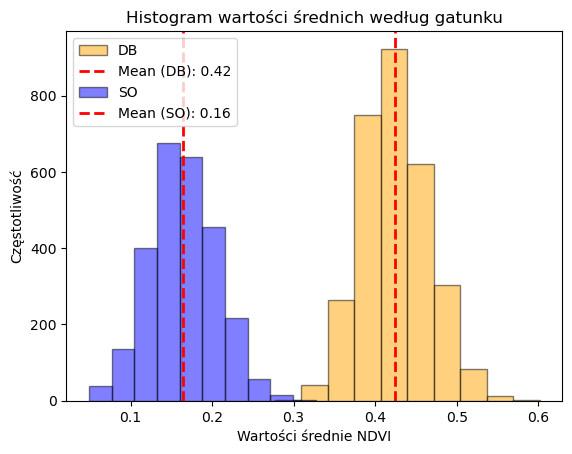

In [23]:
colors = ['orange', 'blue']
plot_histogram_all(df, colors)

## Parametry dla Sosny

**Statystyki opisowe dla gatunku 'SO':**

**Miary pozycyjne:**
- Średnia arytmetyczna: 0.16486043726990143
- Mediana: 0.16289376500000002
- Moda: 0.04902203

**Miary przeciętne:**
- Średnia arytmetyczna: 0.16486043726990143
- Średnia harmoniczna: 0.15346692899481953
- Średnia geometryczna: 0.0

**Miary zmienności klasyczne:**
- Wariancja: 0.0017045115313393045
- Odchylenie standardowe: 0.04128573035976601

**Miary pozycyjne dla zmiennych ilościowych:**
- Kwartyl 1 (Q1): 0.1361851875
- Kwartyl 3 (Q3): 0.19286027
- Rozstęp międzykwartylowy: 0.0566750825
ylowy: 0.0566750825

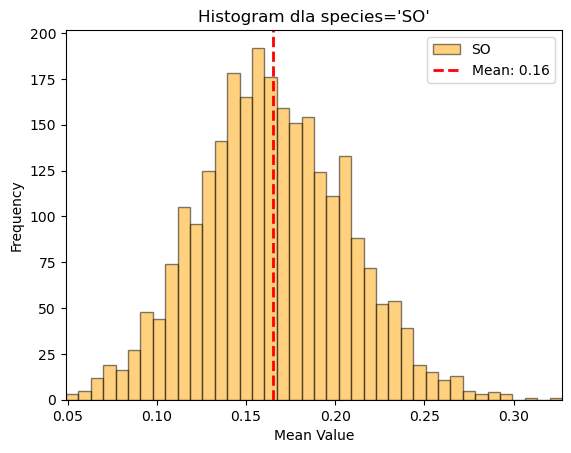

In [24]:
plot_histogram(df, species='SO', color='orange')

In [25]:
descriptive_statistics(df,species='SO')

Statystyki opisowe dla gatunku 'SO':

Miary pozycyjne:
Średnia arytmetyczna: 0.16486043726990143
Mediana: 0.16289376500000002
Moda: 0.04902203

Miary przeciętne:
Średnia arytmetyczna: 0.16486043726990143
Średnia harmoniczna: 0.15346692899481953
Średnia geometryczna: 0.0

Miary zmienności klasyczne:
Wariancja: 0.0017045115313393045
Odchylenie standardowe: 0.04128573035976601

Miary pozycyjne dla zmiennych ilościowych:
Kwartyl 1 (Q1): 0.1361851875
Kwartyl 3 (Q3): 0.19286027
Rozstęp międzykwartylowy: 0.0566750825


## Parametry dla dębu
## Statystyki opisowe dla gatunku DB

**Miary pozycyjne:**
- Średnia arytmetyczna: 0.4243005584733333
- Mediana: 0.42180143999999997
- Moda: 0.3600402

**Miary przeciętne:**
- Średnia arytmetyczna: 0.4243005584733333
- Średnia harmoniczna: 0.42035434595669174
- Średnia geometryczna: 0.0

**Miary zmienności klasyczne:**
- Wariancja: 0.0016796518236727545
- Odchylenie standardowe: 0.04098355552746436

**Miary pozycyjne dla zmiennych ilościowych:**
- Kwartyl 1 (Q1): 0.39590554499999997
- Kwartyl 3 (Q3): 0.45235550999999996
- Rozstęp międzykwartylowy: 0.05644996499999999

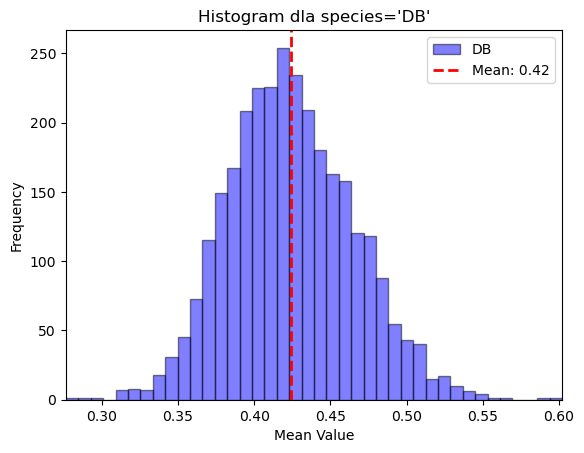

In [31]:
plot_histogram(df, species='DB', color='blue')


In [32]:
descriptive_statistics(df,species='DB')

Statystyki opisowe dla gatunku 'DB':

Miary pozycyjne:
Średnia arytmetyczna: 0.4243005584733333
Mediana: 0.42180143999999997
Moda: 0.3600402

Miary przeciętne:
Średnia arytmetyczna: 0.4243005584733333
Średnia harmoniczna: 0.42035434595669174
Średnia geometryczna: 0.0

Miary zmienności klasyczne:
Wariancja: 0.0016796518236727545
Odchylenie standardowe: 0.04098355552746436

Miary pozycyjne dla zmiennych ilościowych:
Kwartyl 1 (Q1): 0.39590554499999997
Kwartyl 3 (Q3): 0.45235550999999996
Rozstęp międzykwartylowy: 0.05644996499999999


## Test Shapiro-Wilka dla SO

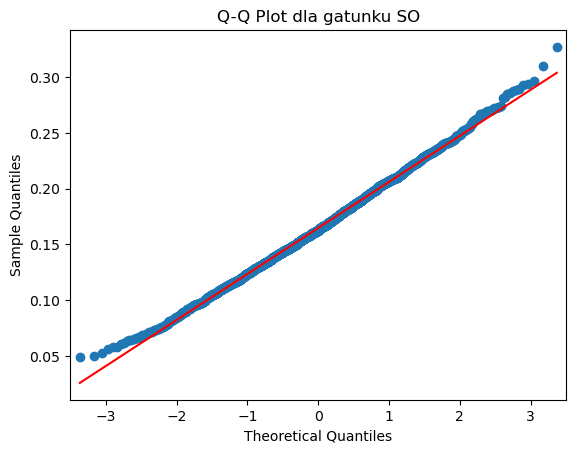

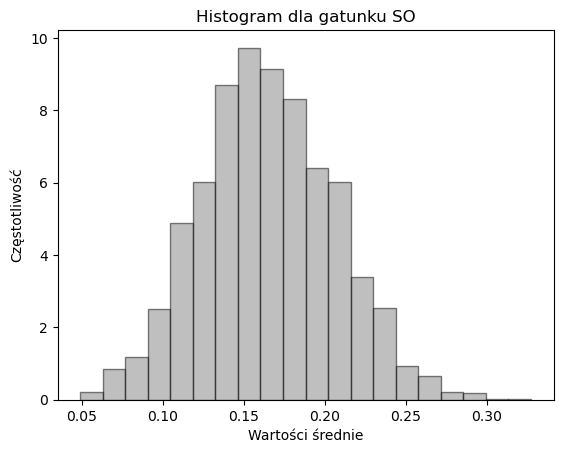

Test Shapiro-Wilka dla gatunku SO:
Statystyka testowa: 0.9979913830757141
Wartość p: 0.0020150956697762012
Hipoteza zerowa (rozkład normalny) jest odrzucana.


In [39]:
assess_normality(df, species='SO')

## Test Shapiro-Wilka dla DB

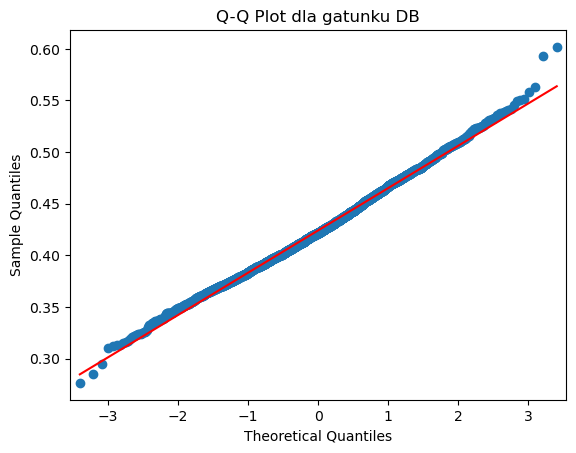

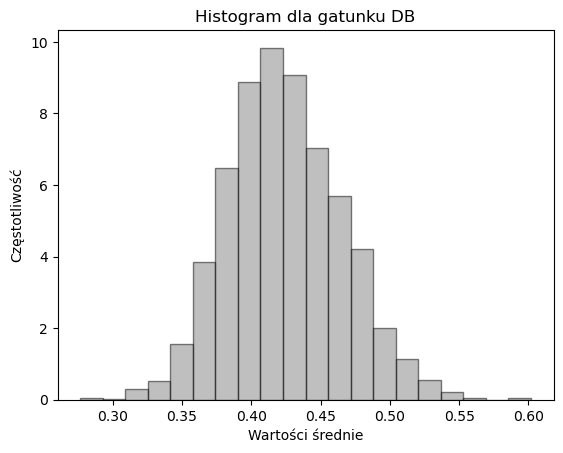

Test Shapiro-Wilka dla gatunku DB:
Statystyka testowa: 0.9962971806526184
Wartość p: 9.341939062323945e-07
Hipoteza zerowa (rozkład normalny) jest odrzucana.


In [41]:
assess_normality(df, species='DB')

## Test U Manna-Whitneya

**Test U Manna-Whitneya:**

statystyka U = 42.0, p-wartość = 0.0
**
Istnieją istotne różnice między grupa**mi

Test U Manna-Whitneya: statystyka U = 42.0, p-wartość = 0.0


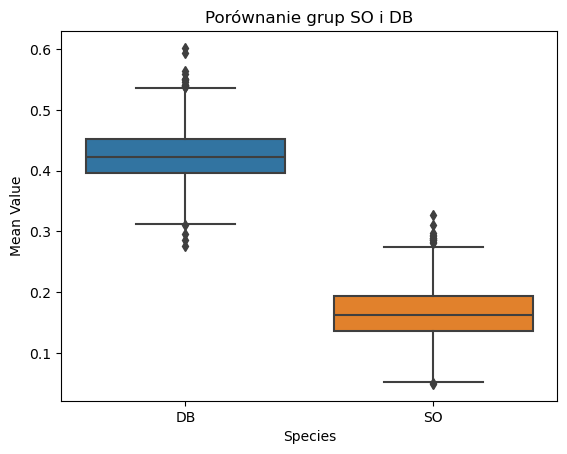

In [44]:
compare_groups(df, 'SO', 'DB')

# Trenowanie modelu

Wyniki oceny modelu są następujące:

Dokładność (Accuracy): Wynosi 100%, co oznacza, że model poprawnie sklasyfikował wszystkie próbki w zbiorze testowym.

Macierz pomyłek (Confusion Matrix): Pokazuje, że:
- 615 próbek dla gatunku DB zostało poprawnie sklasyfikowanych jako DB (True Positives).
- 510 próbek dla gatunku SO zostało poprawnie sklasyfikowanych jako SO (True Positives).
- 3 próbki dla gatunku SO zostały błędnie sklasyfikowane jako DB (False Negatives).
- Nie ma błędnych sklasyfikowań dla gatunku DB.

Raport klasyfikacji (Classification Report): Zapewnia szczegółowe informacje na temat wyników klasyfikacji dla każdej klasy, w tym precision, recall, f1-score i support (liczba próbek w danej klasie).
- Precision (precyzja) dla obu klas wynosi 100%, co oznacza, że wszystkie pozytywne predykcje dla danej klasy są prawidłowe.
- Recall (czułość) dla klasy DB wynosi 100%, a dla klasy SO wynosi 99%, co oznacza, że większość próbek dla każdej klasy została poprawnie zidentyfikowana.
- F1-score dla obu klas wynosi 100%, co oznacza dobrą równowagę między precyzją a czułością.
- Support określa liczbę próbek w każdej klasie.

Rozmiar zbioru treningowego i testowego: W zbiorze treningowym znajduje się 4510 próbek, a w zbiorze testowym 1128 próbek.


In [46]:
#Impor bibliotek
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import joblib

In [47]:
#Import zbioru danych
def read_csv_pandas(path_to_file):
    df = pd.read_csv(path_to_file, sep=';')
    return df

df = read_csv_pandas(r'C:\python_zaliczenie\CSV\trees.csv')

In [51]:
# Trenowanie modelu

# Podziel dane na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(df['mean'].values.reshape(-1, 1), df['species'], test_size=0.2, random_state=42)

# Wytrenuj prosty model regresji logistycznej
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Określ ścieżkę, pod którą zapiszesz model
model_path = "C:\python_zaliczenie\model\so_db_model.joblib"

# Zapisz model do zmiennej 'model_path'
joblib.dump(model, model_path)

# Przewiduj na zbiorze testowym
y_pred = model.predict(X_test)

# Ocen jakość modelu
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Wyświetl wyniki
print(f'Accuracy: {accuracy:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

print("Rozmiar zbioru treningowego:", len(X_train))
print("Rozmiar zbioru testowego:", len(X_test))


Accuracy: 1.00
Confusion Matrix:
[[615   0]
 [  3 510]]
Classification Report:
              precision    recall  f1-score   support

          DB       1.00      1.00      1.00       615
          SO       1.00      0.99      1.00       513

    accuracy                           1.00      1128
   macro avg       1.00      1.00      1.00      1128
weighted avg       1.00      1.00      1.00      1128

Rozmiar zbioru treningowego: 4510
Rozmiar zbioru testowego: 1128


# Wyniki dla danych testowych (nie znanych przez model)

## Ocena modelu

Dokładność (Accuracy): Wynosi 98%, co oznacza, że model poprawnie sklasyfikował 98% wszystkich próbek w zbiorze testowym.

Macierz pomyłek (Confusion Matrix): Pokazuje, że:
- 486 próbek dla gatunku DB zostało poprawnie sklasyfikowanych jako DB (True Positives), natomiast 18 próbek zostało błędnie sklasyfikowanych jako SO (False Negatives).
- Wszystkie 600 próbek dla gatunku SO zostało poprawnie sklasyfikowanych jako SO (True Positives), bez błędów.

Raport klasyfikacji (Classification Report): Zapewnia szczegółowe informacje na temat wyników klasyfikacji dla każdej klasy, w tym precision, recall, f1-score i support (liczba próbek w danej klasie).
- Precyzja (Precision) dla klasy DB wynosi 100%, co oznacza, że wszystkie pozytywne predykcje dla klasy DB są prawidłowe. Dla klasy SO precyzja wynosi 97%, co oznacza, że większość pozytywnych predykcji dla klasy SO jest prawidłowa.
- Czułość (Recall) dla klasy DB wynosi 96%, co oznacza, że model zidentyfikował 96% wszystkich rzeczywistych próbek klasy DB. Dla klasy SO czułość wynosi 100%, co oznacza, że model zidentyfikował wszystkie rzeczywiste próbki klasy SO.
- F1-score dla klasy DB wynosi 98%, a dla klasy SO wynosi 99%, co oznacza, że model osiągnął dobrą równowagę między precyzją a czułością dla obu klas.
- Support określa liczbę próbek w każdej klasie.

Rozmiar zbioru testowego: W zbiorze testowym znajduje się 1104 próbek.



In [52]:
#import biblitek
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


In [56]:
# Wczytaj model (upewnij się, że wcześniej model został zapisany)
model_path = "C:\python_zaliczenie\model\so_db_model.joblib"
model = joblib.load(model_path)

# Wczytaj dane testowe z pliku CSV
test_data = pd.read_csv(r'C:\python_zaliczenie\CSV\trees_results_for_testing_model.csv', sep=';')

# Dodaj numer ID do danych wynikowych
test_data['id'] = test_data['id'].astype(str)  # Jeśli numer ID jest liczbą, zamień na tekst
test_data['id'] = test_data['id'] + '_predicted'  # Dodaj '_predicted' do numeru ID

# Przewiduj gatunki dla danych testowych
predicted_classes = model.predict(test_data['mean'].values.reshape(-1, 1))
predicted_probabilities = model.predict_proba(test_data['mean'].values.reshape(-1, 1))[:, 1]

# Dodaj przewidziane gatunki i prawdopodobieństwa do danych wynikowych
test_data['predicted_species'] = predicted_classes
test_data['predicted_probabilities'] = predicted_probabilities

In [57]:
# Sprawdź dokładność modelu
accuracy = accuracy_score(test_data['species'], predicted_classes)
conf_matrix = confusion_matrix(test_data['species'], predicted_classes)
classification_rep = classification_report(test_data['species'], predicted_classes)

# Wyświetl wyniki dokładności
print(f'Accuracy: {accuracy:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.98
Confusion Matrix:
[[486  18]
 [  0 600]]
Classification Report:
              precision    recall  f1-score   support

          DB       1.00      0.96      0.98       504
          SO       0.97      1.00      0.99       600

    accuracy                           0.98      1104
   macro avg       0.99      0.98      0.98      1104
weighted avg       0.98      0.98      0.98      1104



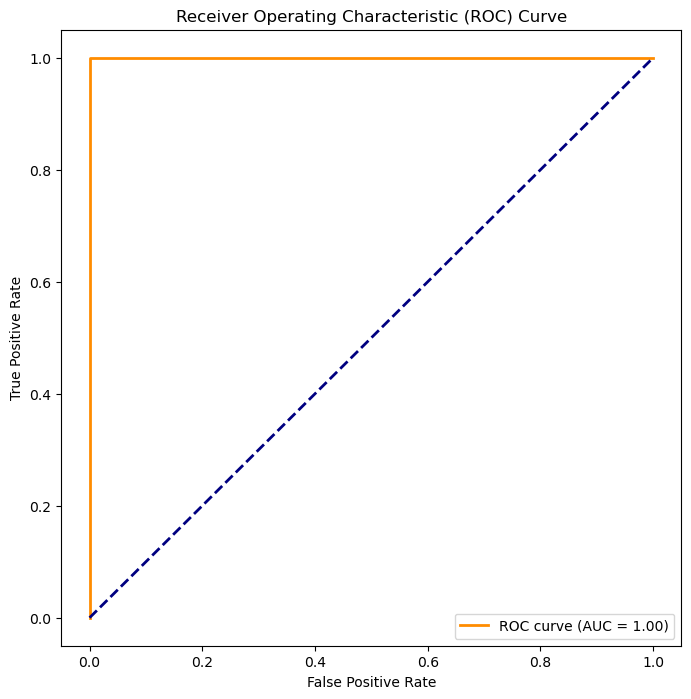

In [61]:
# Oblicz krzywą ROC
fpr, tpr, thresholds = roc_curve(test_data['species'], predicted_probabilities, pos_label='SO')
roc_auc = auc(fpr, tpr)

# Wykres krzywej ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [59]:
# Zapisz wyniki do nowego pliku CSV
test_data.to_csv(r'C:\python_zaliczenie\CSV\test_results.csv', index=False)

# Wyświetl wyniki
print(test_data[['id', 'mean', 'species', 'predicted_species', 'predicted_probabilities']])

                   id      mean species predicted_species  \
0     11278_predicted  0.348585      DB                DB   
1     11279_predicted  0.415473      DB                DB   
2     11280_predicted  0.370652      DB                DB   
3     11281_predicted  0.399752      DB                DB   
4     11282_predicted  0.319520      DB                DB   
...               ...       ...     ...               ...   
1099  12377_predicted  0.144427      SO                SO   
1100  12378_predicted  0.168115      SO                SO   
1101  12379_predicted  0.139620      SO                SO   
1102  12380_predicted  0.147586      SO                SO   
1103  12381_predicted  0.184157      SO                SO   

      predicted_probabilities  
0                    0.199945  
1                    0.045746  
2                    0.126598  
3                    0.066005  
4                    0.338688  
...                       ...  
1099                 0.974745  
1100       